# **Project 2**, APS1070 Fall 2021
**Anomaly Detection Algorithm using Gaussian Mixture Model [13 Marks]**

**Deadline: OCT 22, 9 PM**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Name: Yiwei Han
*   Student Number: 1003841970

##**Part 1: Getting started [1.5 Marks]**

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there? 284807 **[0.1]**
* What features in the dataset are present aside from the 28 main features?  Time, Amount and Class **[0.1]**
* Which column contains the targets? the last column(Class) **[0.1]**
* To what do the target values correspond? if it is credit card fraud **[0.1]**

In [320]:
pip install wget

In [321]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar (8).gz'

In [322]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [324]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [325]:
#how many rows are there
print(df.shape[0])

#what features in the dataset are present aside from the 28 main features?
print("Time, Amount and Class")

#which column contains the targets
print("the last column called Class")

#to what do the target values correspond
print("if it is credit card fraud (0-not fraud, 1-fraud)")

284807
Time, Amount and Class
the last column called Class
if it is credit card fraud (0-not fraud, 1-fraud)



* What is the percentage of entries in the dataset for each class? 99.827% and 0.173% **[0.1]**
* Is this data considered balanced or unbalanced? Why is this the case?_____ **[0.1]**
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1? _____ **[0.2]**



In [326]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [327]:
#what is the percentage of entries in the dataset for each class
pclass0 = 284315/284807
pclass1 = 492/284807
print("percentage of not credit card fraud:", pclass0*100,"%")
print("percentage of credit card fraud:", pclass1*100,"%")

percentage of not credit card fraud: 99.82725143693798 %
percentage of credit card fraud: 0.1727485630620034 %


####Is this data considered balanced or unbalanced? Why is this the case?
This data is extremely unbalanced since percentage of not credit card fraud(99.827%) is much higher than the percentage of credit card fraud(0.173%). In this case, most of the credit card transactions are not fraud and a very few classes are fraud transactions.

####Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1?
In this case, the non-fraud transactions far outweigh the fraud transactions. If we use KNN classifier without fixing this problem, the model will be completely biased, all data will be classified as non-fraud transactions.

Next, split the dataset into a training (70%), validation (15%) and testing set (15%). Set the random state to 0. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [328]:
#split the dataset
X = df.drop(columns=['Class'])
y_true = df['Class']

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y_true, train_size=0.7, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=0)

#training set, validation set, and testing set
#print(X_train)
#print(X_val)
#print(X_test)

Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

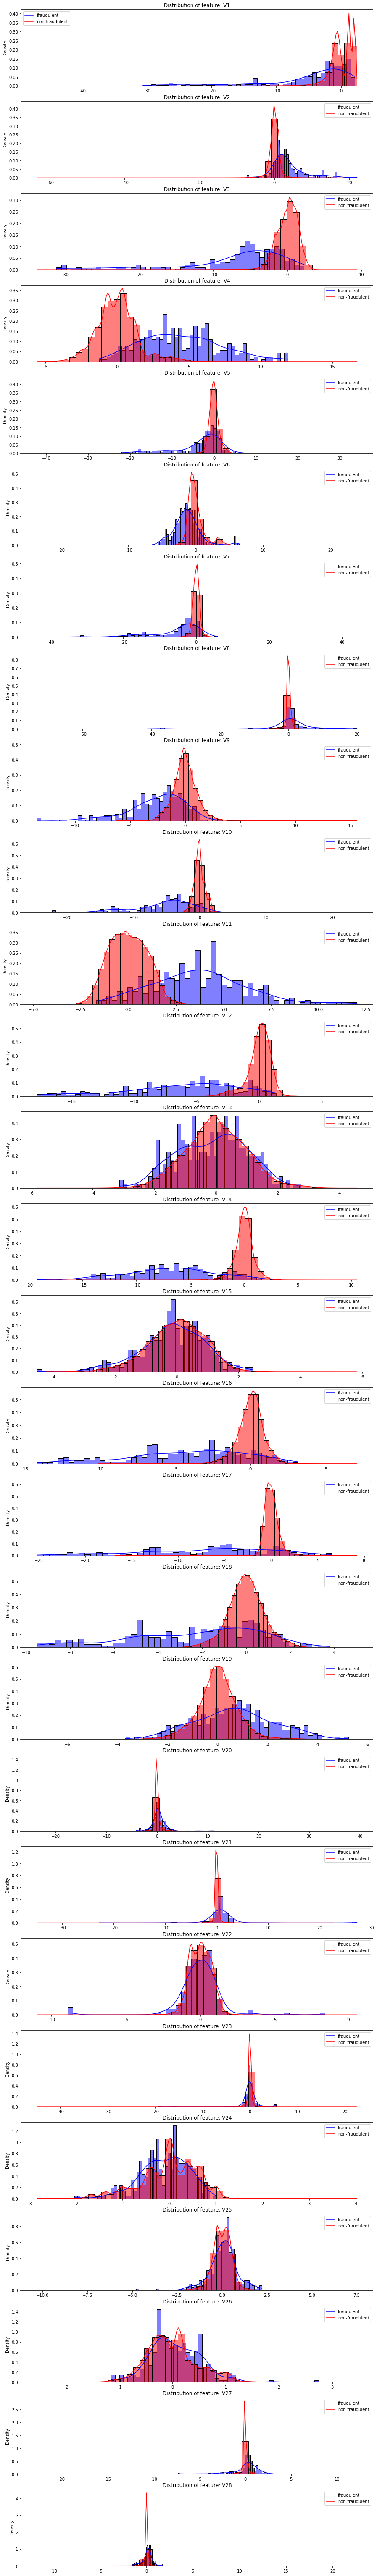

In [329]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

####Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**
From these graphs, we can see different distributions of features in different classes, and most of them followed the gaussian distribution. Therefore, we can get the distance from sample to the centre point, which is the mean value of the feature. The smaller distance, the less likely the anomaly is.

## **Part 2: Single feature model with one Gaussian distribution: [2.5 Marks]**
We'll start by making a prediction using **a single feature of our dataset at a time**. 

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table. 
  4. Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set. **[0.2]**
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`. **[0.5]**
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.**[0.5]**

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a. 
 2. Compute AUC and F1 score when you fit a Gaussian **only on non-fraudulent transactions** (instead of all the transactions).
 3. Compare your results from parts 2a and 2b (AUC and F1 score) in a table. **[0.8]**
 4. Are these results different or similar? Why?**[0.5]**





In [330]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import roc_auc_score

#find the best 3 features
feature_list = []
for i in X_train.keys():
  feature_list.append(i)
feature_list

d = {'train':{},'val':{}}
for feature in feature_list:
    gm = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
    gm.fit(X_train[feature].values.reshape(-1,1))
    predscore_y = gm.score_samples(X_train[feature].values.reshape(-1,1))
    train_auc = metrics.roc_auc_score(y_train, 1-predscore_y ) 
    valscore_y = gm.score_samples(X_val[feature].values.reshape(-1,1))
    val_auc = metrics.roc_auc_score(y_val, 1-valscore_y ) 
    d['train'][feature] = train_auc
    d['val'][feature] = val_auc

feadf = pd.DataFrame(d)
feadf

,train,val
Time,0.510726,0.481849
V1,0.705102,0.694811
V2,0.837499,0.837800
V3,0.876537,0.838364
V4,0.892103,0.888283
V5,0.771825,0.786857
V6,0.734380,0.673559
V7,0.862967,0.867423
V8,0.773238,0.774130
V9,0.802874,0.776739


####Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set:
V4, V10, V14

In [331]:
dfval = X_val[['V4','V10','V14']]
dfval

,V4,V10,V14
109846,-1.581058,-1.569156,-0.999275
269086,0.335727,-0.110171,-0.003988
19318,-1.395785,-0.656373,-0.084297
8453,-0.920164,-0.304604,2.076511
153173,-0.217748,-0.644576,0.954123
...,...,...,...
14334,2.865696,0.954808,0.586792
117234,-0.535052,-1.263317,0.631402
33280,0.503316,0.061904,0.494939
83248,0.984245,-0.378394,0.711091


In [332]:
from sklearn.metrics import f1_score

#find optimal threshold & maximum F1 Score for best 3 features
#feature V4
V4gm = GaussianMixture(n_components = 1, 
                       covariance_type = 'full', random_state=0, )
V4gm.fit(X_train['V4'].values.reshape(-1,1))
p_V4gm = V4gm.score_samples(X_val['V4'].values.reshape(-1,1))
thresholds = sorted(list(set(p_V4gm[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_V4gm < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
print('feature V4: optimal threshold is', thresholds[f1score.index(max(f1score))], 
      'with the maximum F1 Score:', max(f1score))

#feature V10
V10gm = GaussianMixture(n_components = 1, 
                       covariance_type = 'full', random_state=0, )
V10gm.fit(X_train['V10'].values.reshape(-1,1))
p_V10gm = V10gm.score_samples(X_val['V10'].values.reshape(-1,1))
thresholds = sorted(list(set(p_V10gm[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_V10gm < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
print('feature V10: optimal threshold is', thresholds[f1score.index(max(f1score))], 
      'with the maximum F1 Score:', max(f1score))

#feature V14
V14gm = GaussianMixture(n_components = 1, 
                       covariance_type = 'full', random_state=0, )
V14gm.fit(X_train['V14'].values.reshape(-1,1))
p_V14gm = V14gm.score_samples(X_val['V14'].values.reshape(-1,1))
thresholds = sorted(list(set(p_V14gm[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_V14gm < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
print('feature V14: optimal threshold is', thresholds[f1score.index(max(f1score))], 
      'with the maximum F1 Score:', max(f1score))

feature V4: optimal threshold is -8.856822348413715 with the maximum F1 Score: 0.3484848484848485
feature V10: optimal threshold is -58.454523398551025 with the maximum F1 Score: 0.23529411764705882
feature V14: optimal threshold is -19.698972756843407 with the maximum F1 Score: 0.5785123966942148


####Report the complexity of your method (Big O notation) for determining the optimal threshold：
The complexity of my method for determining the optimal threshold is O(logn).

In [333]:
#best AUC: V4, V10, V14
#compute AUC and F1 score(only on non-fraudulent transactions)

#feature V4
V4gm = GaussianMixture(n_components = 1, 
                       covariance_type = 'full', random_state=0, )
V4gm.fit(X_train.loc[y_train == 0]['V4'].values.reshape(-1,1))
p_V4gm = V4gm.score_samples(X_val['V4'].values.reshape(-1,1))

V4val_auc = metrics.roc_auc_score(y_val, 1-p_V4gm)
V4nonfraud_f1 = metrics.f1_score(y_val, p_V4gm < -19.904048181954234)
print('feature V4: AUC(non-fraud) is', V4val_auc, ' with F1 Score(non-fraud):', V4nonfraud_f1)

#feature V10
V10gm = GaussianMixture(n_components = 1, 
                        covariance_type = 'full', random_state=0, )
V10gm.fit(X_train.loc[y_train == 0]['V10'].values.reshape(-1,1))
p_V10gm = V10gm.score_samples(X_val['V10'].values.reshape(-1,1))

V10val_auc = metrics.roc_auc_score(y_val, 1-p_V10gm ) 
V10nonfraud_f1 = metrics.f1_score(y_val, p_V10gm < -57.49950417427245)
print('feature V10: AUC(non-fraud) is', V10val_auc, ' with F1 Score(non-fraud):', V10nonfraud_f1)

#feature V14
V14gm = GaussianMixture(n_components = 1, 
                        covariance_type = 'full', random_state=0, )
V14gm.fit(X_train.loc[y_train == 0]['V14'].values.reshape(-1,1))
p_V14gm = V14gm.score_samples(X_val['V14'].values.reshape(-1,1))

V14val_auc = metrics.roc_auc_score(y_val, 1-p_V14gm ) 
V14nonfraud_f1 = metrics.f1_score(y_val, p_V14gm < -7.448065302926649)
print('feature V14: AUC(non-fraud) is', V14val_auc, ' with F1 Score(non-fraud):', V14nonfraud_f1)

feature V4: AUC(non-fraud) is 0.8888025759513026  with F1 Score(non-fraud): 0.15
feature V10: AUC(non-fraud) is 0.9058995359396576  with F1 Score(non-fraud): 0.24
feature V14: AUC(non-fraud) is 0.9380723335075922  with F1 Score(non-fraud): 0.26666666666666666


In [334]:
#present in table
aucf1table = {"2a_AUC":{"V4":0.888283,"V10":0.905959,"V14":0.938073},
              "2a_F1_Score":{"V4":0.3484848484848485,"V10":0.23529411764705882,"V14":0.5785123966942148}, 
              "2b_AUC":{"V4":0.8888025759513026,"V10":0.9058995359396576,"V14":0.9380723335075922}, 
              "2b_F1_Score":{"V4":0.15,"V10":0.24,"V14":0.26666666666666666}}
aucf1table_df = pd.DataFrame(aucf1table)
aucf1table_df

,2a_AUC,2a_F1_Score,2b_AUC,2b_F1_Score
V4,0.888283,0.348485,0.888803,0.150000
V10,0.905959,0.235294,0.905900,0.240000
V14,0.938073,0.578512,0.938072,0.266667


####Are these results different or similar? Why?
Most of these results are similar with each other. According to the table, the AUC in 2a and 2b are really similar with each other, and the F1 scores in 2a and 2b have slightly differences. In this case, the data is unbalanced. Meanwhile, the fraudulent transactions only occupy 0.173% of the whole data and the non-fraudulent transactions occupy 99.827%, which means most datas will be classified to class0 as non-fraudulent transactions. Therefore, removing the non-fraudulent transaction have little impacts on the validation predict result.


## **Part 3: Multiple feature model with one Gaussian distribution: [1 Marks]**
This part is similar to Part 2, but we will pick multiple features and **visually** set the number of components.

  a. 2D plot:
 1. Pick two features (say, f1 and f2). 
 2. Scatter plot (plt.scatter) those features on a figure (f1 on the x-axis and f2 on the y-axis). 
 3. Color the data points based on their class (non-fraudulent blue and fraudulent red).
 4. Based on your plots, decide how many Gaussian components (``n_components``) you need to fit the data (focus on valid transactions). Explain.  **[0.25]**
 5. Fit your Gaussian model on all the data points. 
 6. Compute AUC on both training and validation sets 
 7. Pick 3 new pairs of features and repeat steps 2 to 6. **[0.25]**
 8. For each pair, find a threshold to maximize your validation set F1 Score.**[0.25]**
 9. For each pair, plot a figure similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in the tutorial) **[0.25]**





####feature V1 and feature V2

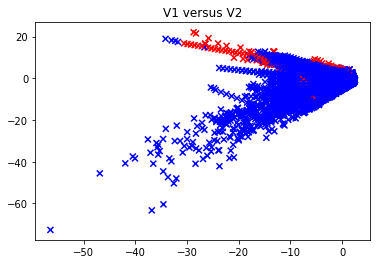

In [335]:
#Scatter plot two features(V1,V2)
map_color = {0: 'b', 1: 'r'}
color = list(map(lambda x: map_color[x], y_true))
plt.title('V1 versus V2')
plt.scatter(df.loc[:,['V1']],df.loc[:,['V2']],marker="x",c = color)

####Based on your plots, decide how many Gaussian components (n_components) you need to fit the data (focus on valid transactions). Explain:
I think we need 3 Gaussian components(n_components) to fit the data. From the scatter plot, although the boundary of clustering is not obvious, I divide it into three parts. The x-axis and y-axis represent V1 and V2 respectively. The first cluster: V1 < -25 and V2 < -20, the second cluster: V1 > -25, and the third cluster: V1 < -25 and V2 > -20.

In [336]:
#features(V1, V2)
#fit Gaussian model on all the data points
V1V2gm = GaussianMixture(n_components = 3,
                         covariance_type = 'full', random_state=0, )
V1V2gm.fit(X.loc[:,['V1','V2']])

#compute AUC on training and validation sets
p_V1V2tragm = V1V2gm.score_samples(X_train.loc[:,['V1','V2']])
V1V2train_auc = metrics.roc_auc_score(y_train, 1-p_V1V2tragm )

p_V1V2valgm = V1V2gm.score_samples(X_val.loc[:,["V1","V2"]])
V1V2val_auc = metrics.roc_auc_score(y_val, 1-p_V1V2valgm )

print('(V1,V2) The AUC on training set is', V1V2train_auc)
print('(V1,V2) The AUC on validation set is', V1V2val_auc)

#find a threshold to maximize your validation set F1 Score
thresholds = sorted(list(set(p_V1V2valgm[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_V1V2valgm < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
print('(V1,V2) Optimal threshold is', thresholds[f1score.index(max(f1score))])
print('(V1,V2) Maximum F1 Score is', max(f1score))

(V1,V2) The AUC on training set is 0.8832354874572823
(V1,V2) The AUC on validation set is 0.8751327061415387
(V1,V2) Optimal threshold is -10.732706714723664
(V1,V2) Maximum F1 Score is 0.08620689655172413


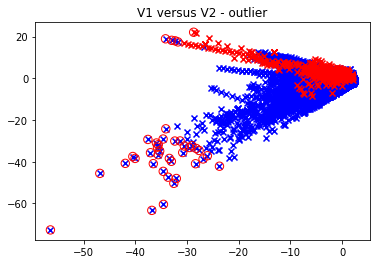

In [337]:
#outlier plot(V1,V2)
V1V2gm = GaussianMixture(n_components = 3,
                         covariance_type = 'full', random_state=0, )
V1V2gm.fit(df[{'V1','V2'}])
V1V2score = V1V2gm.score_samples(df[{'V1','V2'}].values.reshape(-1,2))
outliers = np.nonzero(V1V2score < -57.49950417427245)[0]

plt.title('V1 versus V2 - outlier')
plt.scatter(df[{'V1'}][df["Class"] == 0], df[{'V2'}][df["Class"] == 0], marker="x", color='blue')
plt.scatter(df[{'V1'}][df["Class"] == 1], df[{'V2'}][df["Class"] == 1], marker="x", color='red')
plt.scatter(df[{'V1'}].loc[outliers], df[{'V2'}].loc[outliers], marker="o",facecolor="none",edgecolor="r",s=70)

####feature V3 and feature V23

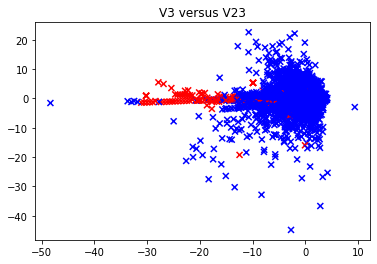

In [338]:
#Scatter plot two features(V3,V23)
map_color = {0: 'b', 1: 'r'}
color = list(map(lambda x: map_color[x], y_true))
plt.title('V3 versus V23')
plt.scatter(df.loc[:,['V3']],df.loc[:,['V23']],marker="x",c = color)

In [339]:
#features(V3, V23)
#fit Gaussian model on all the data points
V3V23gm = GaussianMixture(n_components = 3,
                         covariance_type = 'full', random_state=0, )
V3V23gm.fit(X.loc[:,['V3','V23']])

#compute AUC on training and validation sets
p_V3V23tragm = V3V23gm.score_samples(X_train.loc[:,['V3','V23']])
V3V23train_auc = metrics.roc_auc_score(y_train, 1-p_V3V23tragm )

p_V3V23valgm = V3V23gm.score_samples(X_val.loc[:,["V3","V23"]])
V3V23val_auc = metrics.roc_auc_score(y_val, 1-p_V3V23valgm )

print('(V3,V23) The AUC on training set is', V3V23train_auc)
print('(V3,V23) The AUC on validation set is', V3V23val_auc)

#find a threshold to maximize your validation set F1 Score
thresholds = sorted(list(set(p_V3V23valgm[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_V3V23valgm < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
print('(V3,V23) Optimal threshold is', thresholds[f1score.index(max(f1score))])
print('(V3,V23) Maximum F1 Score is', max(f1score))

(V3,V23) The AUC on training set is 0.8844178667377981
(V3,V23) The AUC on validation set is 0.8429868522068236
(V3,V23) Optimal threshold is -13.78455998643959
(V3,V23) Maximum F1 Score is 0.20754716981132074


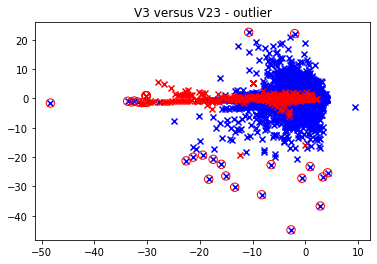

In [340]:
#outlier plot(V3,V23)
V3V23gm = GaussianMixture(n_components = 3,
                          covariance_type = 'full', random_state=0, )
V3V23gm.fit(df[{'V3','V23'}])
V3V23score = V3V23gm.score_samples(df[{'V3','V23'}].values.reshape(-1,2))
outliers = np.nonzero(V3V23score < -45.38437448740396)[0]

plt.title('V3 versus V23 - outlier')
plt.scatter(df[{'V3'}][df["Class"] == 0], df[{'V23'}][df["Class"] == 0], marker="x", color='blue')
plt.scatter(df[{'V3'}][df["Class"] == 1], df[{'V23'}][df["Class"] == 1], marker="x", color='red')
plt.scatter(df[{'V3'}].loc[outliers], df[{'V23'}].loc[outliers], marker="o",facecolor="none",edgecolor="r",s=70)

####feature V5 and feature V8

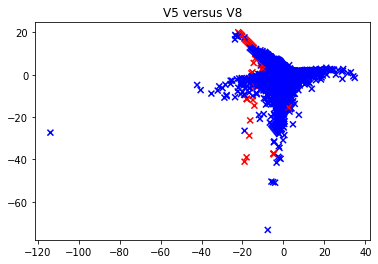

In [341]:
#Scatter plot two features(V5,V8)
map_color = {0: 'b', 1: 'r'}
color = list(map(lambda x: map_color[x], y_true))
plt.title('V5 versus V8')
plt.scatter(df.loc[:,['V5']],df.loc[:,['V8']],marker="x",c = color)

In [342]:
#features(V5, V8)
#fit Gaussian model on all the data points
V5V8gm = GaussianMixture(n_components = 3,
                         covariance_type = 'full', random_state=0, )
V5V8gm.fit(X.loc[:,['V5','V8']])

#compute AUC on training and validation sets
p_V5V8tragm = V5V8gm.score_samples(X_train.loc[:,['V5','V8']])
V5V8train_auc = metrics.roc_auc_score(y_train, 1-p_V5V8tragm )

p_V5V8valgm = V5V8gm.score_samples(X_val.loc[:,["V5","V8"]])
V5V8val_auc = metrics.roc_auc_score(y_val, 1-p_V5V8valgm )

print('(V5,V8) The AUC on training set is', V5V8train_auc)
print('(V5,V8) The AUC on validation set is', V5V8val_auc)

#find a threshold to maximize your validation set F1 Score
thresholds = sorted(list(set(p_V5V8valgm[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_V5V8valgm < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
print('(V5,V8) Optimal threshold is', thresholds[f1score.index(max(f1score))])
print('(V5,V8) Maximum F1 Score is', max(f1score))

(V5,V8) The AUC on training set is 0.8222146002956093
(V5,V8) The AUC on validation set is 0.8321254187635462
(V5,V8) Optimal threshold is -10.514770972801744
(V5,V8) Maximum F1 Score is 0.09049773755656107


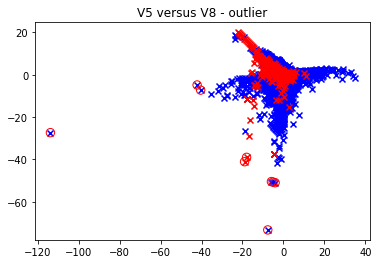

In [343]:
#outlier plot(V5,V8)
V5V8gm = GaussianMixture(n_components = 3,
                         covariance_type = 'full', random_state=0, )
V5V8gm.fit(df[{'V5','V8'}])
V5V8score = V5V8gm.score_samples(df[{'V5','V8'}].values.reshape(-1,2))
outliers = np.nonzero(V5V8score < -57.49950417427245)[0]

plt.title('V5 versus V8 - outlier')
plt.scatter(df[{'V5'}][df["Class"] == 0], df[{'V8'}][df["Class"] == 0], marker="x", color='blue')
plt.scatter(df[{'V5'}][df["Class"] == 1], df[{'V8'}][df["Class"] == 1], marker="x", color='red')
plt.scatter(df[{'V5'}].loc[outliers], df[{'V8'}].loc[outliers], marker="o",facecolor="none",edgecolor="r",s=70)

####feature V7 and feature V17

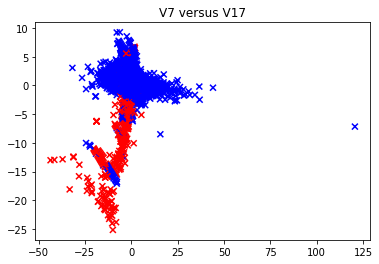

In [344]:
#Scatter plot two features(V7,V17)
map_color = {0: 'b', 1: 'r'}
color = list(map(lambda x: map_color[x], y_true))
plt.title('V7 versus V17')
plt.scatter(df.loc[:,['V7']],df.loc[:,['V17']],marker="x",c = color)

In [345]:
#features(V7, V17)
#fit Gaussian model on all the data points
V7V17gm = GaussianMixture(n_components = 3,
                         covariance_type = 'full', random_state=0, )
V7V17gm.fit(X.loc[:,['V7','V17']])

#compute AUC on training and validation sets
p_V7V17tragm = V7V17gm.score_samples(X_train.loc[:,['V7','V17']])
V7V17train_auc = metrics.roc_auc_score(y_train, 1-p_V7V17tragm )

p_V7V17valgm = V7V17gm.score_samples(X_val.loc[:,["V7","V17"]])
V7V17val_auc = metrics.roc_auc_score(y_val, 1-p_V7V17valgm )

print('(V7,V17) The AUC on training set is', V7V17train_auc)
print('(V7,V17) The AUC on validation set is', V7V17val_auc)

#find a threshold to maximize your validation set F1 Score
thresholds = sorted(list(set(p_V7V17valgm[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_V7V17valgm < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
print('(V7,V17) Optimal threshold is', thresholds[f1score.index(max(f1score))])
print('(V7,V17) Maximum F1 Score is', max(f1score))

(V7,V17) The AUC on training set is 0.947751853275097
(V7,V17) The AUC on validation set is 0.9303010198690049
(V7,V17) Optimal threshold is -11.574078555359073
(V7,V17) Maximum F1 Score is 0.4406779661016949


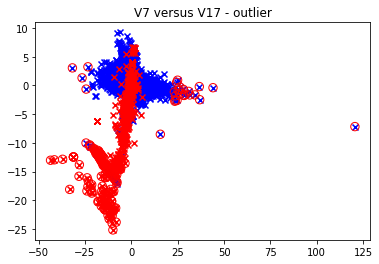

In [346]:
#outlier plot(V7,V17)
V7V17gm = GaussianMixture(n_components = 3,
                         covariance_type = 'full', random_state=0, )
V7V17gm.fit(df[{'V7','V17'}])
V7V17score = V7V17gm.score_samples(df[{'V7','V17'}].values.reshape(-1,2))
outliers = np.nonzero(V7V17score < -17.96837597999177)[0]

plt.title('V7 versus V17 - outlier')
plt.scatter(df[{'V7'}][df["Class"] == 0], df[{'V17'}][df["Class"] == 0], marker="x", color='blue')
plt.scatter(df[{'V7'}][df["Class"] == 1], df[{'V17'}][df["Class"] == 1], marker="x", color='red')
plt.scatter(df[{'V7'}].loc[outliers], df[{'V17'}].loc[outliers], marker="o",facecolor="none",edgecolor="r",s=70)

## **Part 4: Single feature model with two Gaussian distributions. [2 Marks]**
Now we will use two different distributions for fraudulent and non-fraudulent transactions.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **non-fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively. **[0.25]**
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the transaction is classified as a fraud. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the transaction is a fraud (the transaction belongs to the $G_2$ distribution which represents fraudulent transactions). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed. **[0.25]**
  5. Repeat the steps above for all the features. What is the best F1 Score that you get for training and validation? Which feature and what c? **[1]**

In [347]:
#fit Gaussian distribution
G1 = GaussianMixture(n_components = 1).fit(X_train.loc[y_train==0,["V1"]].values.reshape(-1,1))
G2 = GaussianMixture(n_components = 1).fit(X_train.loc[y_train==1,["V1"]].values.reshape(-1,1))

#compute score samples(validation set)
S1 = G1.score_samples(X_val.loc[:,["V1"]].values.reshape(-1,1))      
S2 = G2.score_samples(X_val.loc[:,["V1"]].values.reshape(-1,1))  

In [348]:
#find the optimal 𝑐 that maximizes validation set F1 Score
y_val_pred = np.zeros(S1.shape[0])
best_c = 0
best_f1 = 0
for c in range(10,100,1):
    c = c/10.0
    for i in range(y_val_pred.shape[0]):
        if S1[i] < c*S2[i]:
            y_val_pred[i] = 1
        else:
            y_val_pred[i] = 0
    f1 = metrics.f1_score(y_val, y_val_pred)
    if f1 > best_f1:
        best_c = c
        best_f1 = f1

print("optimal c:", best_c)
print("maximum F1 Score:", best_f1)

optimal c: 5.0
maximum F1 Score: 0.0970873786407767


In [349]:
#best F1 Score for validation, feature and c
best_c_train = 0
best_f1 = 0
best_feature = "Unknown"
for feature in features:
    G1 = GaussianMixture(n_components = 1 ).fit(X_train.loc[y_train==0,[feature]].values.reshape(-1,1))
    G2 = GaussianMixture(n_components = 1 ).fit(X_train.loc[y_train==1,[feature]].values.reshape(-1,1))
    S1 = G1.score_samples(X_val.loc[:,[feature]].values.reshape(-1,1))      
    S2 = G2.score_samples(X_val.loc[:,[feature]].values.reshape(-1,1))  
    y_val_pred = np.zeros(S1.shape[0])
    for c in range(10,100,1):
        c = c/10.0
        for i in range(y_val_pred.shape[0]):
            if S1[i] < c*S2[i]:
                y_val_pred[i] = 1
            else:
                y_val_pred[i] = 0
   
        f1 = metrics.f1_score(y_val, y_val_pred)
        if f1 > best_f1:
            best_c = c
            best_f1 = f1
            best_feature = feature

print("best F1 Score for validation:", best_f1)
print("feature:", best_feature)
print("c:", best_c)

best F1 Score for validation: 0.6545454545454547
feature: V17
c: 7.2


In [350]:
#best F1 Score for training
feature = "V17"
G1 = GaussianMixture(n_components = 1).fit(X_train.loc[y_train==0,[feature]].values.reshape(-1,1))
G2 = GaussianMixture(n_components = 1).fit(X_train.loc[y_train==1,[feature]].values.reshape(-1,1))
S1 = G1.score_samples(X_train.loc[:,[feature]].values.reshape(-1,1))      
S2 = G2.score_samples(X_train.loc[:,[feature]].values.reshape(-1,1)) 
y_train_pred = np.zeros(S1.shape[0])
for i in range(y_val_pred.shape[0]):
    if S1[i] < c*S2[i]:
        y_train_pred[i] = 1
    else:
        y_train_pred[i] = 0
train_f1 = metrics.f1_score(y_train, y_train_pred)

print("best F1 Score for training:", train_f1)

best F1 Score for training: 0.16410256410256413


####What is the best F1 Score that you get for training and validation? Which feature and what c?
The best F1 Score for validation dataset is 0.6545454545454547 while c is 7.2 and the feature is V17. After executing out these paramenters, we can find the best F1 Score for training dataset, which is 0.16410256410256413.

## **Part 5: Multivariate and Mixture of Gaussians Distribution [4 Marks]**
We now want to build an outlier detection model that performs well in terms of F1 score. To design your model, you can benefit from:

*   No restrictions on the number of features - use as few or as many as you want! (multivariate). 
*   To fit your model, you can take advantage of the Gaussian mixture model, where you can set the number of components [help](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).
*   You can choose to fit your Gaussians on non-fraudulent transactions or to both classes. 


It is up to you how to design your model. Try at least 10 different models and report the AUC for both training and validation sets (if applicable) and the best F1 score for both training and validation sets for each model. What kind of model works better? How many features are best (and which ones)? How many Gaussians? How many components? Summarize your findings with tables or plots. **[4]**


**HINT !**

You might want to try a two-gaussian model, multiple features, a single component for the valid transaction, and multiple components for fraudulent ones! Why does it make sense to have multiple components for fraudulent transactions?

In [351]:
#Model-1: Single-Gaussian with 3 features (components = 1)
gm1 = GaussianMixture(n_components=1).fit(X_train.loc[:,['V4','V10','V14']])
p_gm_train = gm1.score_samples(X_train.loc[:,['V4','V10','V14']])
auc_train1 = metrics.roc_auc_score(y_train, 1-p_gm_train) 
p_gm_val = gm1.score_samples(X_val.loc[:,['V4','V10','V14']])
auc_val1 = metrics.roc_auc_score(y_val, 1-p_gm_val)
thresholds = sorted(list(set(p_gm_val[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_gm_val < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
bestf1_val1 = max(f1score)
best_threshold = thresholds[f1score.index(max(f1score))]
pred_train = (p_gm_train < best_threshold)
bestf1_train1 = f1_score(y_train, pred_train)
print("training AUC:", auc_train1, "validation AUC:", auc_val1, 
      "trainning F1 Score:", bestf1_train1, "validation F1 Score:", bestf1_val1)

training AUC: 0.9632681928045468 validation AUC: 0.9483966438730529 trainning F1 Score: 0.4720327421555252 validation F1 Score: 0.3970588235294118


In [352]:
#Model-2: Single-Gaussian with 3 features used valid transaction (components = 1)
gm2 = GaussianMixture(n_components=1).fit(X_train.loc[y_train==0,['V4','V10','V14']])
p_gm_train = gm2.score_samples(X_train.loc[:,['V4','V10','V14']])
auc_train2 = metrics.roc_auc_score(y_train, 1-p_gm_train) 
p_gm_val = gm2.score_samples(X_val.loc[:,['V4','V10','V14']])
auc_val2 = metrics.roc_auc_score(y_val, 1-p_gm_val)
thresholds = sorted(list(set(p_gm_val[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_gm_val < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
bestf1_val2 = max(f1score)
best_threshold = thresholds[f1score.index(max(f1score))]
pred_val = (p_gm_val < best_threshold)
bestf1_val2 = f1_score(y_val, pred_val)
pred_train = (p_gm_train < best_threshold)
bestf1_train2 = f1_score(y_train, pred_train)
print("training AUC:", auc_train2, "validation AUC:", auc_val2, 
      "trainning F1 Score:", bestf1_train2, "validation F1 Score:", bestf1_val2)

training AUC: 0.9646649715404785 validation AUC: 0.9490740837939995 trainning F1 Score: 0.5034770514603616 validation F1 Score: 0.4393939393939394


In [353]:
#Model-3: Single-Gaussion with all features used valid transaction (components = 1)
gm3 = GaussianMixture(n_components=1).fit(X_train.loc[y_train==0,features])
p_gm_train = gm3.score_samples(X_train.loc[:,features])
auc_train3 = metrics.roc_auc_score(y_train, 1-p_gm_train) 
p_gm_val = gm3.score_samples(X_val.loc[:,features])
auc_val3 = metrics.roc_auc_score(y_val, 1-p_gm_val)
thresholds = sorted(list(set(p_gm_val[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_gm_val < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
bestf1_val3 = max(f1score)
best_threshold = thresholds[f1score.index(max(f1score))]
pred_val = (p_gm_val < best_threshold)
bestf1_val3 = f1_score(y_val, pred_val)
pred_train = (p_gm_train < best_threshold)
bestf1_train3 = f1_score(y_train, pred_train)
print("training AUC:", auc_train3, "validation AUC:", auc_val3, 
      "trainning F1 Score:", bestf1_train3, "validation F1 Score:", bestf1_val3)

training AUC: 0.9583206934360867 validation AUC: 0.935440955302262 trainning F1 Score: 0.5145482388973965 validation F1 Score: 0.4957264957264957


In [354]:
#Model-4: Single-Gaussion with 5 features used valid transaction (components = 1)
gm4 = GaussianMixture(n_components=1).fit(X_train.loc[y_train==0,['V4','V14','V24','V10','V20']])
p_gm_train = gm4.score_samples(X_train.loc[:,['V4','V14','V24','V10','V20']])
auc_train4 = metrics.roc_auc_score(y_train, 1-p_gm_train) 
p_gm_val = gm4.score_samples(X_val.loc[:,['V4','V14','V24','V10','V20']])
auc_val4 = metrics.roc_auc_score(y_val, 1-p_gm_val)
thresholds = sorted(list(set(p_gm_val[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_gm_val < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
bestf1_val4 = max(f1score)
best_threshold = thresholds[f1score.index(max(f1score))]
pred_val = (p_gm_val < best_threshold)
bestf1_val4 = f1_score(y_val, pred_val)
pred_train = (p_gm_train < best_threshold)
bestf1_train4 = f1_score(y_train, pred_train)
print("training AUC:", auc_train4, "validation AUC:", auc_val4, 
      "trainning F1 Score:", bestf1_train4, "validation F1 Score:", bestf1_val4)

training AUC: 0.9663178761389835 validation AUC: 0.9436073255889633 trainning F1 Score: 0.35082458770614694 validation F1 Score: 0.3025210084033613


In [355]:
#Model-5: Single-Gaussion with 3 features (components = 5)
gm5 = GaussianMixture(n_components=5).fit(X_train.loc[:,['V4','V10','V14']])
p_gm_train = gm5.score_samples(X_train.loc[:,['V4','V10','V14']])
auc_train5 = metrics.roc_auc_score(y_train, 1-p_gm_train) 
p_gm_val = gm5.score_samples(X_val.loc[:,['V4','V10','V14']])
auc_val5 = metrics.roc_auc_score(y_val, 1-p_gm_val)
thresholds = sorted(list(set(p_gm_val[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_gm_val < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
bestf1_val5 = max(f1score)
best_threshold = thresholds[f1score.index(max(f1score))]
pred_train = (p_gm_train < best_threshold)
bestf1_train5 = f1_score(y_train, pred_train)
print("training AUC:", auc_train5, "validation AUC:", auc_val5, 
      "trainning F1 Score:", bestf1_train5, "validation F1 Score:", bestf1_val5)

training AUC: 0.9643077993208863 validation AUC: 0.9604978343617403 trainning F1 Score: 0.39168110918544197 validation F1 Score: 0.3571428571428571


In [356]:
#Model-6: Single-Gaussian with 3 features used valid transaction (components = 5)
gm6 = GaussianMixture(n_components=5).fit(X_train.loc[y_train==0,['V4','V10','V14']])
p_gm_train = gm6.score_samples(X_train.loc[:,['V4','V10','V14']])
auc_train6 = metrics.roc_auc_score(y_train, 1-p_gm_train) 
p_gm_val = gm6.score_samples(X_val.loc[:,['V4','V10','V14']])
auc_val6 = metrics.roc_auc_score(y_val, 1-p_gm_val)
thresholds = sorted(list(set(p_gm_val[y_val == 1])))
f1score = []
for t in thresholds:
  pred_val = (p_gm_val < t).astype(int)
  f1score.append(f1_score(y_val, pred_val))
bestf1_val6 = max(f1score)
best_threshold = thresholds[f1score.index(max(f1score))]
pred_val = (p_gm_val < best_threshold)
bestf1_val6 = f1_score(y_val, pred_val)
pred_train = (p_gm_train < best_threshold)
bestf1_train6 = f1_score(y_train, pred_train)
print("training AUC:", auc_train6, "validation AUC:", auc_val6, 
      "trainning F1 Score:", bestf1_train6, "validation F1 Score:", bestf1_val6)

training AUC: 0.9656299802706187 validation AUC: 0.9612977453427755 trainning F1 Score: 0.6351351351351351 validation F1 Score: 0.5607476635514019


In [357]:
#Model-7: Two-Gaussion with 3 features (components = 1)
gm7_1 = GaussianMixture(n_components=1).fit(X_train.loc[y_train==0, ['V4','V10','V14']])
gm7_2 = GaussianMixture(n_components=1).fit(X_train.loc[y_train==1, ['V4','V10','V14']])
S1 = gm7_1.score_samples(X_val[{'V4','V10','V14'}])
S2 = gm7_2.score_samples(X_val[{'V4','V10','V14'}])
best_c = 0
b_f1 = 0
for c in range(10,100,1):
  c = c/10.0
  pred1 = np.where(S1<c*S2, 1, 0)
  f1 = f1_score(y_val,pred1)
  if f1>b_f1:
    best_c = c
    b_f1 = f1
S1_train = gm7_1.score_samples(X_train[{'V4','V10','V14'}])      
S2_train = gm7_2.score_samples(X_train[{'V4','V10','V14'}])
pred_train = np.where(S1_train<best_c*S2_train, 1, 0)
bestf1_train7 = f1_score(y_train,pred_train)
pred_val = np.where(S1<best_c*S2, 1, 0)
bestf1_val7 = f1_score(y_val,pred_val)
auc_train7 = (roc_auc_score(y_train, 1-S1_train) + roc_auc_score(y_train, 1-S2_train))/2
auc_val7 = (roc_auc_score(y_val, 1-S1) + roc_auc_score(y_val, 1-S2))/2
print("training AUC:", auc_train7, "validation AUC:", auc_val7, 
      "trainning F1 Score:", bestf1_train7, "validation F1 Score:", bestf1_val7)

training AUC: 0.9449769743781655 validation AUC: 0.9128326226512675 trainning F1 Score: 0.3861788617886179 validation F1 Score: 0.36170212765957444


In [358]:
#Model-8: Two-Gaussion with all features (components = 1)
gm8_1 = GaussianMixture(n_components=1).fit(X_train.loc[y_train==0, features])
gm8_2 = GaussianMixture(n_components=1).fit(X_train.loc[y_train==1, features])
S1 = gm8_1.score_samples(X_val[features])
S2 = gm8_2.score_samples(X_val[features])
best_c = 0
b_f1 = 0
for c in range(10,100,1):
  c = c/10.0
  pred1 = np.where(S1<c*S2, 1, 0)
  f1 = f1_score(y_val,pred1)
  if f1>b_f1:
    best_c = c
    b_f1 = f1
S1_train = gm8_1.score_samples(X_train[features])      
S2_train = gm8_2.score_samples(X_train[features])
pred_train = np.where(S1_train<best_c*S2_train, 1, 0)
bestf1_train8 = f1_score(y_train,pred_train)
pred_val = np.where(S1<best_c*S2, 1, 0)
bestf1_val8 = f1_score(y_val,pred_val)
auc_train8 = (roc_auc_score(y_train, 1-S1_train) + roc_auc_score(y_train, 1-S2_train))/2
auc_val8 = (roc_auc_score(y_val, 1-S1) + roc_auc_score(y_val, 1-S2))/2
print("training AUC:", auc_train8, "validation AUC:", auc_val8, 
      "trainning F1 Score:", bestf1_train8, "validation F1 Score:", bestf1_val8)

training AUC: 0.626961776499236 validation AUC: 0.6449011098677382 trainning F1 Score: 0.7248520710059172 validation F1 Score: 0.6507936507936508


In [359]:
#Model-9: Two-Gaussion with 3 features (components=3 for nonfraud transaction, components=5 for fraud transaction)
gm9_1 = GaussianMixture(n_components=3).fit(X_train.loc[y_train==0, ['V4','V10','V14']])
gm9_2 = GaussianMixture(n_components=5).fit(X_train.loc[y_train==1, ['V4','V10','V14']])
S1 = gm9_1.score_samples(X_val[{'V4','V10','V14'}])
S2 = gm9_2.score_samples(X_val[{'V4','V10','V14'}])
best_c = 0
b_f1 = 0
for c in range(10,100,1):
  c = c/10.0
  pred1 = np.where(S1<c*S2, 1, 0)
  f1 = f1_score(y_val,pred1)
  if f1>b_f1:
    best_c = c
    b_f1 = f1
S1_train = gm9_1.score_samples(X_train[{'V4','V10','V14'}])      
S2_train = gm9_2.score_samples(X_train[{'V4','V10','V14'}])
pred_train = np.where(S1_train<best_c*S2_train, 1, 0)
bestf1_train9 = f1_score(y_train,pred_train)
pred_val = np.where(S1<best_c*S2, 1, 0)
bestf1_val9 = f1_score(y_val,pred_val)
auc_train9 = (roc_auc_score(y_train, 1-S1_train) + roc_auc_score(y_train, 1-S2_train))/2
auc_val9 = (roc_auc_score(y_val, 1-S1) + roc_auc_score(y_val, 1-S2))/2
print("training AUC:", auc_train9, "validation AUC:", auc_val9, 
      "trainning F1 Score:", bestf1_train9, "validation F1 Score:", bestf1_val9)

training AUC: 0.9618973383285596 validation AUC: 0.9406998626224624 trainning F1 Score: 0.007722007722007723 validation F1 Score: 0.04166666666666666


In [360]:
#Model-10: Two-Gaussion with all features (components=3 for nonfraud transaction, components=5 for fraud transaction)
gm10_1 = GaussianMixture(n_components=3).fit(X_train.loc[y_train==0, features])
gm10_2 = GaussianMixture(n_components=5).fit(X_train.loc[y_train==1, features])
S1 = gm10_1.score_samples(X_val[features])
S2 = gm10_2.score_samples(X_val[features])
best_c = 0
b_f1 = 0
for c in range(10,100,1):
  c = c/10.0
  pred1 = np.where(S1<c*S2, 1, 0)
  f1 = f1_score(y_val,pred1)
  if f1>b_f1:
    best_c = c
    b_f1 = f1
S1_train = gm10_1.score_samples(X_train[features])      
S2_train = gm10_2.score_samples(X_train[features])
pred_train = np.where(S1_train<best_c*S2_train, 1, 0)
bestf1_train10 = f1_score(y_train,pred_train)
pred_val = np.where(S1<best_c*S2, 1, 0)
bestf1_val10 = f1_score(y_val,pred_val)
auc_train10 = (roc_auc_score(y_train, 1-S1_train) + roc_auc_score(y_train, 1-S2_train))/2
auc_val10 = (roc_auc_score(y_val, 1-S1) + roc_auc_score(y_val, 1-S2))/2
print("training AUC:", auc_train10, "validation AUC:", auc_val10, 
      "trainning F1 Score:", bestf1_train10, "validation F1 Score:", bestf1_val10)

training AUC: 0.5785664117277857 validation AUC: 0.6286509497805669 trainning F1 Score: 0.8183206106870229 validation F1 Score: 0.7796610169491525


In [361]:
table_result = {"Type":{"Model1":"Single-Gaussian with 3 features (components = 1)",
                        "Model2":"Single-Gaussian with 3 features used valid transaction (components = 1)",
                        "Model3":"Single-Gaussion with all features used valid transaction (components = 1)",
                        "Model4":"Single-Gaussion with 5 features used valid transaction (components = 1)",
                        "Model5":"Single-Gaussion with 3 features (components = 5)",
                        "Model6":"Single-Gaussian with 3 features used valid transaction (components = 5)",
                        "Model7":"Two-Gaussion with 3 features (components = 1)",
                        "Model8":"Two-Gaussion with all features (components = 1)",
                        "Model9":"Two-Gaussion with 3 features (components=3 for nonfraud transaction, components=5 for fraud transaction)",
                        "Model10":"Two-Gaussion with all features (components=3 for nonfraud transaction, components=5 for fraud transaction)"},
                "F1_score_Train":{"Model1":bestf1_train1,"Model2":bestf1_train2,"Model3":bestf1_train3,"Model4":bestf1_train4,"Model5":bestf1_train5,
                            "Model6":bestf1_train6,"Model7":bestf1_train7,"Model8":bestf1_train8,"Model9":bestf1_train9,"Model10":bestf1_train10},
                "F1_score_Val":{"Model1":bestf1_val1,"Model2":bestf1_val2,"Model3":bestf1_val3,"Model4":bestf1_val4,"Model5":bestf1_val5,
                         "Model6":bestf1_val6,"Model7":bestf1_val7,"Model8":bestf1_val8,"Model9":bestf1_val9,"Model10":bestf1_val10},
                "AUC_Train":{"Model1":auc_train1,"Model2":auc_train2,"Model3":auc_train3,"Model4":auc_train4,"Model5":auc_train5,
                            "Model6":auc_train6,"Model7":auc_train7,"Model8":auc_train8,"Model9":auc_train9,"Model10":auc_train10},
                "AUC_Val":{"Model1":auc_val1,"Model2":auc_val2,"Model3":auc_val3,"Model4":auc_val4,"Model5":auc_val5,
                            "Model6":auc_val6,"Model7":auc_val7,"Model8":auc_val8,"Model9":auc_val9,"Model10":auc_val10}}
pd.DataFrame(table_result)

,Type,F1_score_Train,F1_score_Val,AUC_Train,AUC_Val
Model1,Single-Gaussian with 3 features (components = 1),0.472033,0.397059,0.963268,0.948397
Model2,Single-Gaussian with 3 features used valid tra...,0.503477,0.439394,0.964665,0.949074
Model3,Single-Gaussion with all features used valid t...,0.514548,0.495726,0.958321,0.935441
Model4,Single-Gaussion with 5 features used valid tra...,0.350825,0.302521,0.966318,0.943607
Model5,Single-Gaussion with 3 features (components = 5),0.391681,0.357143,0.964308,0.960498
Model6,Single-Gaussian with 3 features used valid tra...,0.635135,0.560748,0.965630,0.961298
Model7,Two-Gaussion with 3 features (components = 1),0.386179,0.361702,0.944977,0.912833
Model8,Two-Gaussion with all features (components = 1),0.724852,0.650794,0.626962,0.644901
Model9,Two-Gaussion with 3 features (components=3 for...,0.007722,0.041667,0.961897,0.940700
Model10,Two-Gaussion with all features (components=3 f...,0.818321,0.779661,0.578566,0.628651


####What kind of model works better? How many features are best (and which ones)? How many Gaussians? How many components? Summarize your findings with tables or plots.
From the table, we can see Model-10 has the highest F1 Score both on training and validation dataset. This model build by Two-GaussianMixture with 28 features. For nonfraud transaction, it has 3 components. For fraud transaction, it has 5 components. By comparing all 10 models, we find that the effect of the two-GaussianMixture model is much better than that of the single-GaussianMixture model in most cases under the same environment.

## **Part 6: Evaluating performance on test set: [1 Mark]**
**Which model worked better?** Pick your best model among all models and apply it to your test set. Report the F1 Score, precision and recall on the test set. **[1]**


In [362]:
#model-10 is the best model
gm10_1 = GaussianMixture(n_components=3).fit(X_train.loc[y_train==0, features])
gm10_2 = GaussianMixture(n_components=5).fit(X_train.loc[y_train==1, features])
S1 = gm10_1.score_samples(X_val[features])
S2 = gm10_2.score_samples(X_val[features])
best_c = 0
best_f1 = 0
for c in range(10,100,1):
  c = c/10.0
  pred1 = np.where(S1<c*S2, 1, 0)
  f1 = f1_score(y_val,pred1)
  if f1>best_f1:
    best_c = c
    best_f1 = f1
S1_test = gm10_1.score_samples(X_test[features])      
S2_test = gm10_2.score_samples(X_test[features])
pred_test = np.where(S1_test<best_c*S2_test, 1, 0)
bestf1_test10 = f1_score(y_test,pred_test)
precision_test10 = metrics.precision_score(y_test, pred_test)
recall_test10 = metrics.recall_score(y_test, pred_test)
print("Test F1 Score:", bestf1_test10, "Precision:", precision_test10, "Recall:", recall_test10)

Test F1 Score: 0.8343558282208589 Precision: 0.8192771084337349 Recall: 0.85


####Which model worked better? Pick your best model among all models and apply it to your test set. Report the F1 Score, precision and recall on the test set.
Model 10 worked better (Two-Gaussion with all features (components=3 for nonfraud transaction, components=5 for fraud transaction)). The F1 Score on test set is 0.7975460122699387, the precision is 0.7831325301204819 and the recall on the test set is 0.8125.

## **Part 7: Is Gaussian the only useful distribution? [1 Mark]**

####Search for other distributions that could be used to model the data. How popular are they? Is there a specific situation where a distribution works better? How can we find a suitable distribution to model our data? Do not forget to include your references. 

There are many other distributions could be used to model the data, such as Bernoulli's distribution, Binomial distribution, Poisson distribution, Exponential distribution, Multinomial distribution, Beta distribution and so on. The most popular model we used is Bernoulli distribution and Multinomial distribution. 

Each distribution has their own specific situation that can work better. For example, tossing a coin, the success probability of an outcome to be heads is p, then the probability of having tail as outcome is (1-p). Bernoulli’s distribution is the special case of binomial distribution with a single trial. The Bernoulli is mainly used to cluster various binary data sets, and the Multinomial distribution is an extension of binomial distribution,the difference is that in Multinomial distribution has n results in each record.Bernoulli and multinomial are applicable to data with discrete features and labels. 

To check if the distribution is suitable for our data, we can build mixture model, and use evalutor to check the score or error rate. Probability plots might be the best way to determine whether the data follow a particular distribution. If data follow the straight line on the graph, the distribution fits your data. This process is simple to do visually. If all the data points line up within the area of a fat pencil laid over the center straight line, we can conclude the data follow the distribution.

https://www.analyticssteps.com/blogs/10-types-statistical-data-distribution-models

https://statisticsbyjim.com/hypothesis-testing/identify-distribution-data/

https://statisticsbyjim.com/hypothesis-testing/identify-distribution-data/
